<a href="https://colab.research.google.com/github/Janina712/RhythmMetrics_Spectral/blob/main/SpectralAnalysis_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scipy

In [ ]:
!pip install emd==0.6.2

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
import math
import statistics
import emd
from scipy import signal
from scipy.fft import fft, fftshift, fftfreq
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/SpectralAnalysis/

/content/gdrive/MyDrive/SpectralAnalysis


In [ ]:
# load soundfile
Fs, wav = wavfile.read('example.wav')

In [ ]:
# compute time axis
t_wav = []
for i in range(0,len(wav)):
  time = i/Fs
  t_wav.append(time)

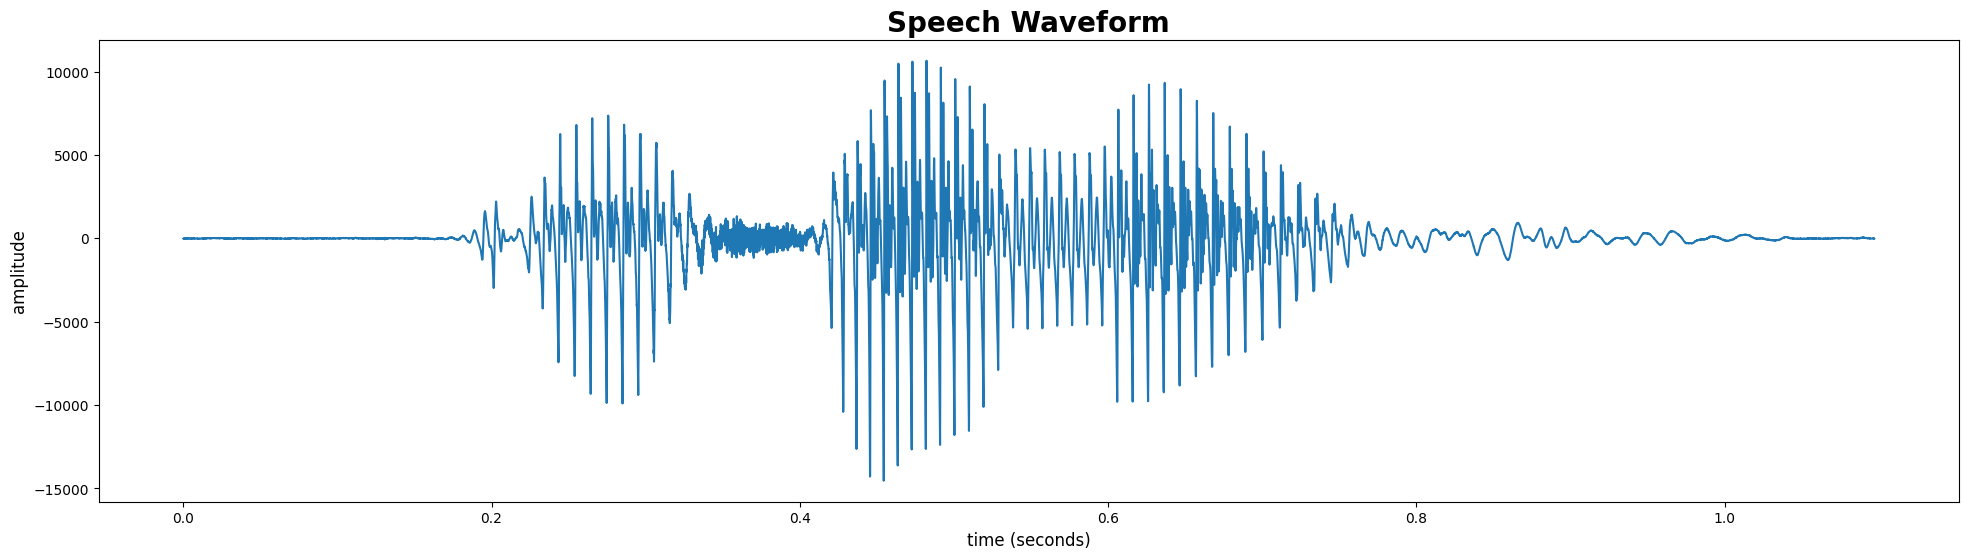

In [ ]:
# visualize soundfile
fig = plt.figure(figsize=(24, 6))
plt.plot(t_wav, wav)
plt.title("Speech Waveform", size = 20, weight = 'bold')
plt.ylabel("amplitude", size = 12)
plt.xlabel("time (seconds)", size = 12);

# **I. Preprocessing**

**1. Remove DC Frequency**

In [ ]:
wav_dc = wav - wav.mean()

**2. Bandpass Filter**

In [ ]:
# parameters
lower_cutoff = 400
upper_cutoff = 4000
order = 4

In [ ]:
# apply filter (zero phase)
b,a = signal.butter(order, [lower_cutoff, upper_cutoff], 'bp', fs=Fs)
filtered = signal.filtfilt(b,a, wav_dc)

**3. Syllabic Envelope**

In [ ]:
# get magnitude (power)
new_filtered = abs(filtered)

In [ ]:
# parameters
order = 4
cutoff = 10

In [ ]:
# apply filter (zero phase)
b,a = signal.butter(order, cutoff, 'lp', fs=Fs)
syll = signal.filtfilt(b,a, new_filtered)

**4. Remove DC Frequency (Again)**

In [ ]:
sig_dc = syll - syll.mean()

**5. Down-Sample**

In [ ]:
# parameters
original_rate = 22050
new_rate = original_rate/100

In [ ]:
# downsample signal & adjust time axis
number_of_samples = round(len(sig_dc) * float(new_rate) /Fs)
sig_down = signal.resample(sig_dc, number_of_samples)
t_env = np.linspace(0, max(wav), len(sig_down), False)

**6. Normalize**

In [ ]:
avg2norm = (sum(sig_down))/len(sig_down)
intermediate = sig_down - avg2norm
norm_signal = intermediate/max(intermediate)

**7. Windowing**

In [ ]:
# Tukey window parameters
M = len(norm_signal)
window = signal.windows.tukey(M, alpha = 0.2)

In [ ]:
wind_signal = window*norm_signal

**8. Plot Preprocessed Signal**

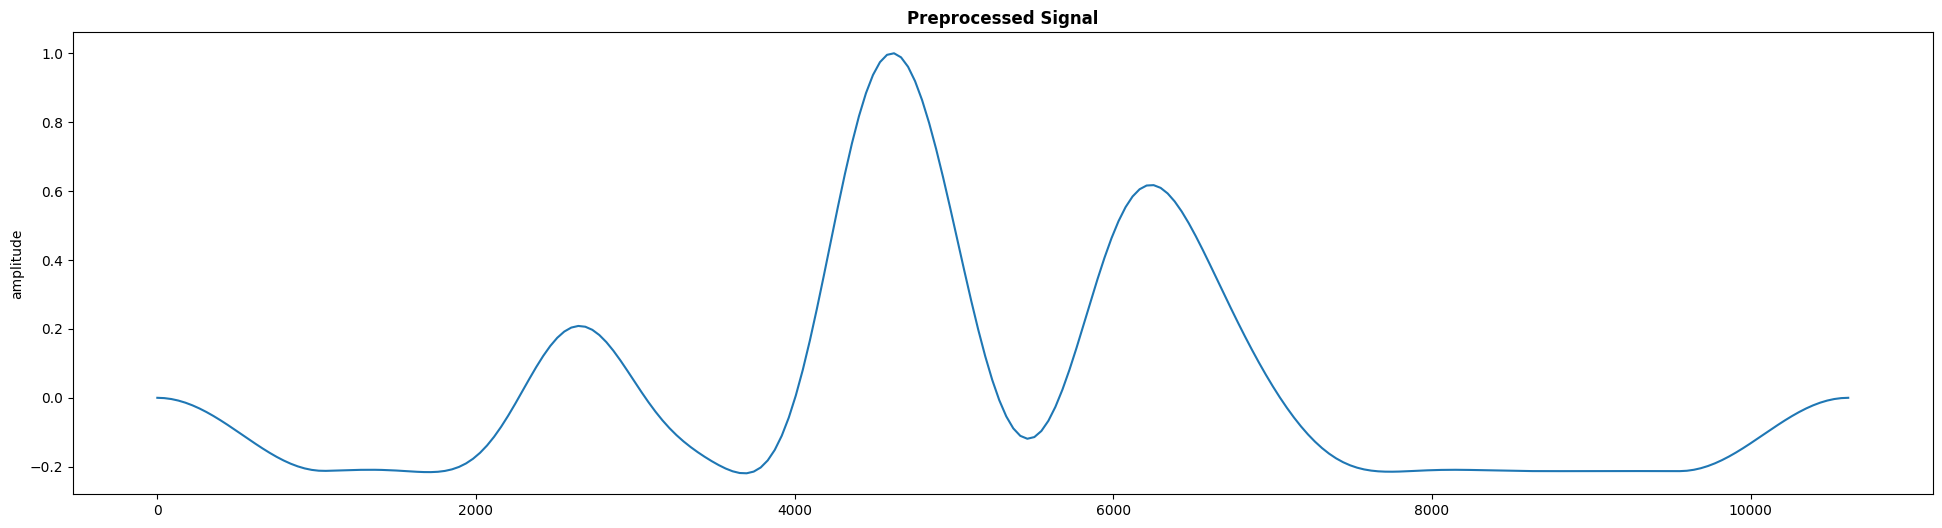

In [ ]:
# plot
fig = plt.figure(figsize=(24, 6))
plt.plot(t_env, wind_signal)
plt.title('Preprocessed Signal', weight = 'bold')
plt.ylabel('amplitude');

# **II. Envelope Spectral Analysis (ESA)**

**1. Zero-Pad**

In [ ]:
# determine length
power_2 = 2**11
to_add = int((power_2 - len(wind_signal))/2)

In [ ]:
# zero-pad
right = np.append(wind_signal, [0]*to_add)
left= np.insert(right, 0, [0]*to_add)
zero_pad = left

**2. Fast Fourier Transform**

In [ ]:
# calculate amplitude spectrum
fourier = fft(zero_pad)
xf = np.fft.fftfreq(len(zero_pad), (1/new_rate))

**3. Get Power**

In [ ]:
# scale FC by length of signal
power = (abs(fourier)**2)/len(fourier)

**4. Normalize**

In [ ]:
# double positive frequencies
norm_spec = power*2
# cancel out negative frequencies
N = len(norm_spec)
power = np.abs(norm_spec[0:N//2])

In [ ]:
# adjust frequency axis
T = 1/new_rate
xf = fftfreq(N, T)[:N//2]

**5. Center Spectrum over 0 and N**

In [ ]:
power_sym = np.concatenate((np.flipud(power), power, np.flipud(power)))

**6. Moving Average**

In [ ]:
# parameters
bin_size = 1
L = round(len(zero_pad)*bin_size/new_rate)

In [ ]:
# apply moving average
smpsd = signal.lfilter((1/L)*np.ones(L),1,power_sym)
smpsd = smpsd[int((N/2)+1):int((N/2)+(N/2))]

**7. Plot Spectrum**

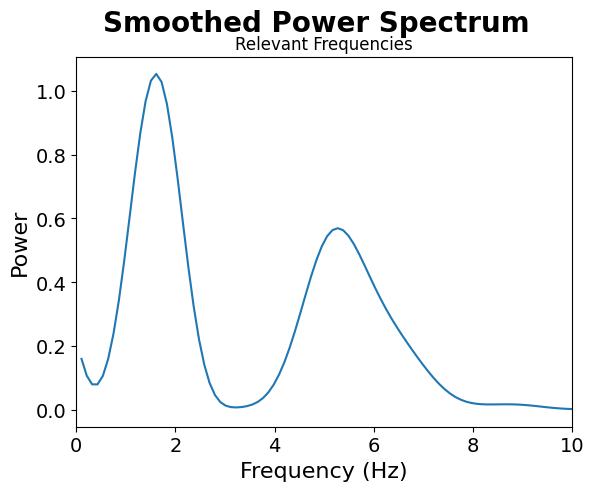

In [ ]:
# plot
plt.plot(xf[1:1024], smpsd)
plt.xlim([0,10])
plt.xlabel("Frequency (Hz)", size = 16)
plt.ylabel("Power", size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.suptitle('Smoothed Power Spectrum', size = 20, weight = "bold")
plt.title("Relevant Frequencies")
plt.show()

#**III. Empirical Mode Decomposition**

**1. Extract IMFs**

In [ ]:
imf = emd.sift.sift(wind_signal, max_imfs=4) # sift_thresh=0.1,

**2. Hilbert Transform**

In [ ]:
analytic_signal_1 = signal.hilbert(imf[:,0])
analytic_signal_2 = signal.hilbert(imf[:,1])

**3. Extract Instantaneous Amplitude, Frequency, and Phase**

In [ ]:
amplitude_envelope_1 = np.abs(analytic_signal_1) # square to get power?
amplitude_envelope_2 = np.abs(analytic_signal_2) # square to get power?

instantaneous_phase_1 = np.unwrap(np.angle(analytic_signal_1))
instantaneous_phase_2 = np.unwrap(np.angle(analytic_signal_2))

instantaneous_frequency_1 = new_rate/(2.0 * np.pi) * np.gradient(instantaneous_phase_1)
instantaneous_frequency_2 = new_rate/(2.0 * np.pi) * np.gradient(instantaneous_phase_2)

**4. Remove Outliers**

In [ ]:
# IMF 1
upper = instantaneous_frequency_1.mean() + 3*instantaneous_frequency_1.std()
lower = instantaneous_frequency_1.mean() - 3*instantaneous_frequency_1.std()

IF_no_1 = instantaneous_frequency_1

for i in range(0,len(IF_no_1)):
  if instantaneous_frequency_1[i] > upper:
    np.delete(IF_no_1,i, 0)
  elif instantaneous_frequency_1[i] < lower:
    np.delete(IF_no_1,i,0)
  else:
    continue

In [ ]:
# IMF 2
upper = instantaneous_frequency_2.mean() + 3*instantaneous_frequency_2.std()
lower = instantaneous_frequency_2.mean() - 3*instantaneous_frequency_2.std()

IF_no_2 = instantaneous_frequency_2

for i in range(0,len(IF_no_2)):
  if instantaneous_frequency_2[i] > upper:
    np.delete(IF_no_2,i, 0)
  elif instantaneous_frequency_2[i] < lower:
    np.delete(IF_no_2,i,0)
  else:
    continue

**5. Plot IMFs**

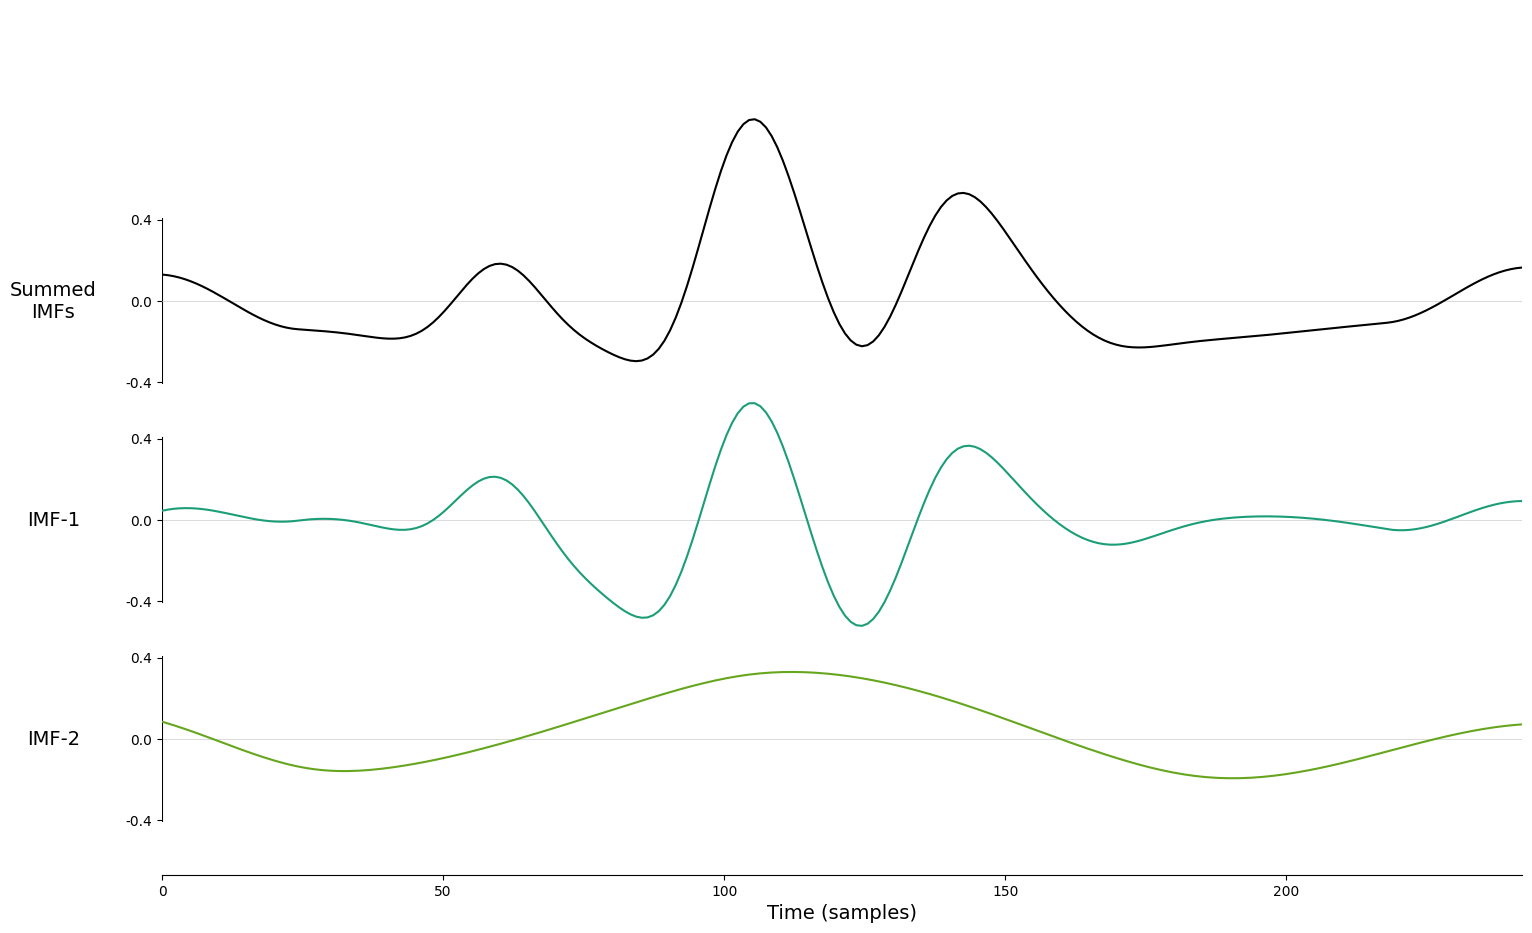

In [ ]:
emd.plotting.plot_imfs(imf);

**6. Plot Instantaneous Frequencies**

In [ ]:
# adjust time axis
t = np.linspace(0,len(imf)/new_rate, len(imf))

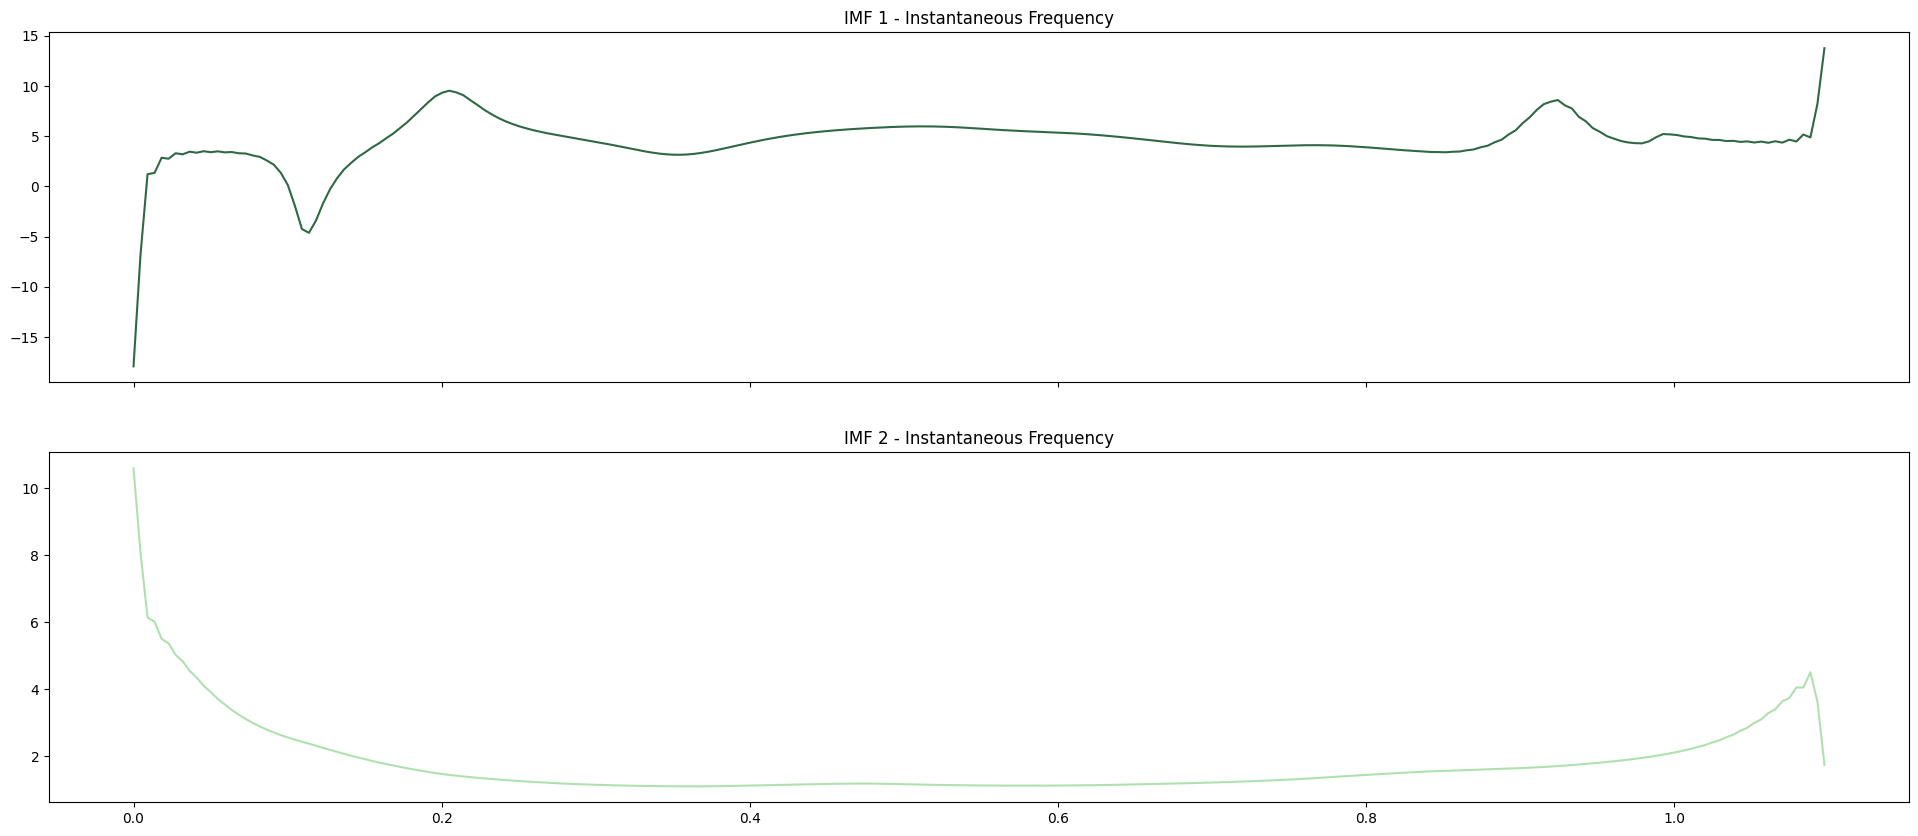

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(24, 10))
ax1.plot(t,IF_no_1, color = '#306844')
ax1.set_title("IMF 1 - Instantaneous Frequency")
ax2.plot(t, IF_no_2, color = '#AFE1AF')
ax2.set_title("IMF 2 - Instantaneous Frequency");

**7. Remove Edges**

In [ ]:
# remove 100 ms from edges
edge = round(new_rate/10)

In [ ]:
# remove edges from IFs
instantaneous_frequency_1_processed = IF_no_1[edge:len(IF_no_1)-edge]
instantaneous_frequency_2_processed = IF_no_2[edge:len(IF_no_2)-edge]

In [ ]:
# remove edges from IAs
amplitude_envelope_1_processed = amplitude_envelope_1[edge:len(IF_no_1)-edge]
amplitude_envelope_2_processed = amplitude_envelope_2[edge:len(IF_no_2)-edge]

# **IV. Rhythm Metrics**

**1. Spectral Band Power Ration (SBPr)**

In [ ]:
supra_idx = np.where((xf >= 1) & (xf <= 3.5))[0]
syll_idx = np.where((xf > 3.5) & (xf <= 10))[0]

In [ ]:
supra_power = []
syll_power = []

for i in range(0,len(supra_idx)):
  supra_power.append(smpsd[supra_idx[i]])
supra = sum(supra_power)

for j in range(0,len(syll_idx)):
  syll_power.append(smpsd[syll_idx[j]])
syll = sum(syll_power)

In [ ]:
SBR_3_0 = supra/syll
print("Percentage (ratio) of power in supra-syllabic oscillations is", round(supra/((supra+syll)/100),2))
print("Percentage (ratio) of power in syllabic oscillations is", round(syll/((supra+syll)/100),2))
print("Ratio SBR_3.25 =", round(supra/syll,2))

Percentage (ratio) of power in supra-syllabic oscillations is 48.17
Percentage (ratio) of power in syllabic oscillations is 51.83
Ratio SBR_3.25 = 0.93


**2. Envelope Spectral Centroid (CNTR)**

In [ ]:
central_idx = np.where((xf >= 1) & (xf <= 10))[0]

In [ ]:
current_sum = 0
for i in range(0,len(central_idx)):
  current_sum = current_sum + (xf[central_idx[i]] * smpsd[central_idx[i]])

In [ ]:
power_sum = 0
for i in range(0,len(central_idx)):
  power_sum = power_sum + smpsd[central_idx[i]]

In [ ]:
CNTR = current_sum/power_sum
print("Centroid =", round(CNTR,2),"Hz")

Centroid = 3.65 Hz


**3. IMF Ratio (IMFr)**

In [ ]:
imf1_power = []
imf2_power = []

for i in range(0,len(amplitude_envelope_1)):
  imf1_power.append(amplitude_envelope_1[i])
imf1 = sum(imf1_power)

for j in range(0,len(amplitude_envelope_2)):
  imf2_power.append(amplitude_envelope_2[j])
imf2 = sum(imf2_power)

In [ ]:
print("IMF1 power: ", imf1)
print("IMF2 power: ", imf2)

IMF1 power:  54.477727174322915
IMF2 power:  53.255290659195886


In [ ]:
IMFr = imf1/imf2
print("IMFr =", round(IMFr,2))

IMFr = 1.02


**4. Syllabic Rate (IMF1)**

In [ ]:
IMF1_rate = sum(IF_no_1)/len(IF_no_1)
print("IMF1_rate =", round(IMF1_rate,2))

IMF1_rate = 4.5


**5. Suprasyllabic Rate (IMF2)**

In [ ]:
IMF2_rate = sum(IF_no_2)/len(IF_no_2)
print("IMF2_rate =", round(IMF2_rate,2))

IMF2_rate = 1.82


**6. Syllabic Rhythm Stability (IMF1)**

In [ ]:
IMF1_stab = statistics.variance(IF_no_1)
print("IMF1_stab =", round(IMF1_stab,2))

IMF1_stab = 6.61


**7. Suprasyllabic Rhythm Stability (IMF2)**

In [ ]:
IMF2_stab = statistics.variance(IF_no_2)
print("IMF2_stab =", round(IMF2_stab,2))

IMF2_stab = 1.4
